In [2]:
import matplotlib.pyplot as plt
import json
data_file = open('../cedict.json', 'r', encoding='utf-8')
data = json.load(data_file)

scores_in = []
scores_ex = []
for d in data:
    scores_in.append(d["word_score_in"])
    scores_ex.append(d["word_score_ex"])

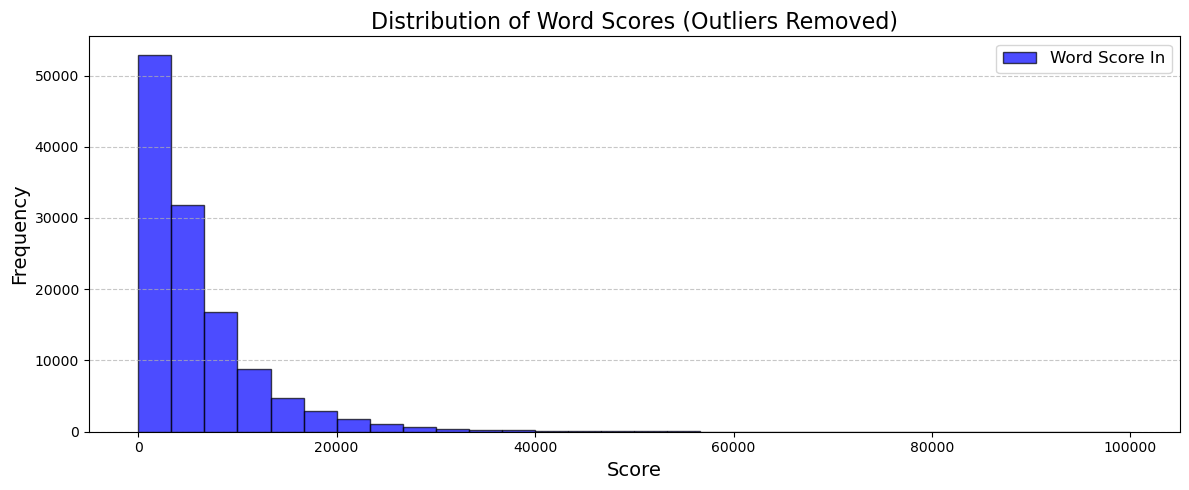

In [3]:
# Set range limits to focus on non-outlier data
plt.figure(figsize=(12, 5))
plt.hist(scores_in, bins=30, range=(0, 100000), alpha=0.7, label='Word Score In', color='blue', edgecolor='black')

# Add labels and legend
plt.title('Distribution of Word Scores (Outliers Removed)', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


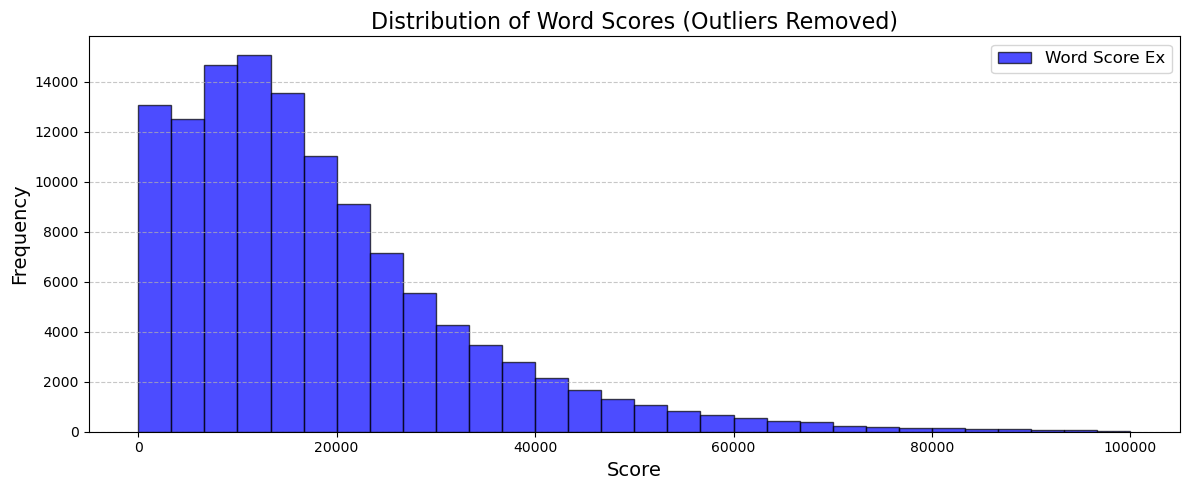

In [4]:
# Set range limits to focus on non-outlier data
plt.figure(figsize=(12, 5))
plt.hist(scores_ex, bins=30, range=(0, 100000), alpha=0.7, label='Word Score Ex', color='blue', edgecolor='black')

# Add labels and legend
plt.title('Distribution of Word Scores (Outliers Removed)', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [5]:
file_paths = ['sentence_db_1.json', 'sentence_db_2.json', 'sentence_db_3.json', 'sentence_db_4.json']
unifiedSentenceDB = {}
for file_path in file_paths:
    with open(f"Mega-Partitions/{file_path}", 'r', encoding='utf-8') as f:
        mega_partition = json.load(f)
        for key, value in mega_partition.items():
            unifiedSentenceDB[key] = value  # Create new key with the data
# with open('Mega-Partitions/sentence_db.json', 'w', encoding='utf-8') as f:
#     json.dump(unifiedSentenceDB, f, ensure_ascii=False, indent=4)

In [6]:
print(len(unifiedSentenceDB.values()))

119231


In [7]:
import numpy as np
deduplicated_dictionary_ex = {}
deduplicated_dictionary_in = {}
for term in data:
    if term["simplified"] not in deduplicated_dictionary_ex:
        deduplicated_dictionary_ex[term["simplified"]] = term["word_score_ex"]
        deduplicated_dictionary_in[term["simplified"]] = term["word_score_in"]

percentiles = np.linspace(0, 100, 17)  # Generate 17 values (from 0 to 100, inclusive)
percentiles_ex = [np.percentile(list(deduplicated_dictionary_ex.values()), p) for p in percentiles]
percentiles_in = [np.percentile(list(deduplicated_dictionary_in.values()), p) for p in percentiles]
print(percentiles_ex)
print(percentiles_in)

[0.0, 1600.0, 4033.75, 6072.625, 7900.5, 9596.375, 11239.0, 12937.0, 14648.0, 16620.875, 18827.0, 21371.0, 24407.0, 28392.75, 34113.5, 43732.0, 562800.0]
[0.0, 293.0, 759.0, 1265.0, 1769.0, 2292.0, 2817.25, 3402.0, 4039.0, 4752.875, 5577.0, 6580.0, 7802.0, 9418.0, 11831.25, 16385.0, 230500.0]


In [8]:
NUM_PARTITIONS = 16
partitions_ex = [{} for _ in range(NUM_PARTITIONS)]
# Breaks: [0.0, 1600.0, 4033.75, 6072.625, 7900.5, 9596.375, 11239.0, 12937.0, 14648.0, 16620.875, 18827.0, 21371.0, 24407.0, 28392.75, 34113.5, 43732.0, 562800.0]
partitions_in = [{} for _ in range(NUM_PARTITIONS)]
# Breaks: [0.0, 293.0, 759.0, 1265.0, 1769.0, 2292.0, 2817.25, 3402.0, 4039.0, 4752.875, 5577.0, 6580.0, 7802.0, 9418.0, 11831.25, 16385.0, 230500.0]
partitionsEmptyCount_ex = [0] * NUM_PARTITIONS
partitionsEmptyCount_in = [0] * NUM_PARTITIONS

for term, sentences in unifiedSentenceDB.items():
    ex_score = deduplicated_dictionary_ex[term]
    partition_idx = 0
    while partition_idx < NUM_PARTITIONS - 1 and ex_score > percentiles_ex[partition_idx + 1]:
        partition_idx += 1

    partitions_ex[partition_idx][term] = sentences
    if len(sentences) == 0:
        partitionsEmptyCount_ex[partition_idx] += 1

for term, sentences in unifiedSentenceDB.items():
    in_score = deduplicated_dictionary_in[term]
    partition_idx = 0
    while partition_idx < NUM_PARTITIONS - 1 and in_score > percentiles_in[partition_idx + 1]:
        partition_idx += 1

    partitions_in[partition_idx][term] = sentences
    if len(sentences) == 0:
        partitionsEmptyCount_in[partition_idx] += 1

In [9]:
deduplicated_scores_prod = []

for term in data:
    key = term["simplified"]
    deduplicated_scores_prod.append(deduplicated_dictionary_ex[key] * deduplicated_dictionary_in[key])

percentiles_prod = [np.percentile(deduplicated_scores_prod, p) for p in percentiles]

print(percentiles_prod)

partitions_prod = [{} for _ in range(NUM_PARTITIONS)]
partitionsEmptyCount_prod = [0] * NUM_PARTITIONS

for term, sentences in unifiedSentenceDB.items():
    prod_score = deduplicated_dictionary_in[term] * deduplicated_dictionary_ex[term]
    partition_idx = 0
    while partition_idx < NUM_PARTITIONS - 1 and prod_score > percentiles_prod[partition_idx + 1]:
        partition_idx += 1

    partitions_prod[partition_idx][term] = sentences
    if len(sentences) == 0:
        partitionsEmptyCount_prod[partition_idx] += 1


[0.0, 450449.5625, 3003123.375, 7759399.0, 14046928.0, 22145887.9375, 32298288.125, 44892505.3125, 60218903.5, 80193620.25, 106695906.75, 141769767.0, 190402179.25, 265075894.1875, 389366662.75, 675395304.9375, 68919500000.0]


EX SCORE PARTITION SIZES
7582 7322 7452 7452 7452 7458 7448 7453 7448 7453 7452 7455 7448 7452 7453 7451 
[2428, 134, 65, 39, 55, 42, 42, 27, 40, 29, 29, 33, 41, 28, 46, 37]

IN SCORE PARTITION SIZES
7493 7414 7450 7458 7450 7447 7455 7450 7450 7460 7447 7451 7456 7446 7453 7451 
[2347, 183, 75, 60, 55, 44, 32, 42, 30, 19, 33, 44, 38, 38, 32, 43]

PROD SCORE PARTITION SIZES
7365 7318 7436 7493 7509 7548 7540 7542 7553 7552 7519 7518 7505 7480 7360 6993 
[2439, 116, 58, 59, 50, 33, 39, 40, 36, 32, 28, 32, 38, 44, 29, 42]


Text(0.5, 1.0, 'In score empty count')

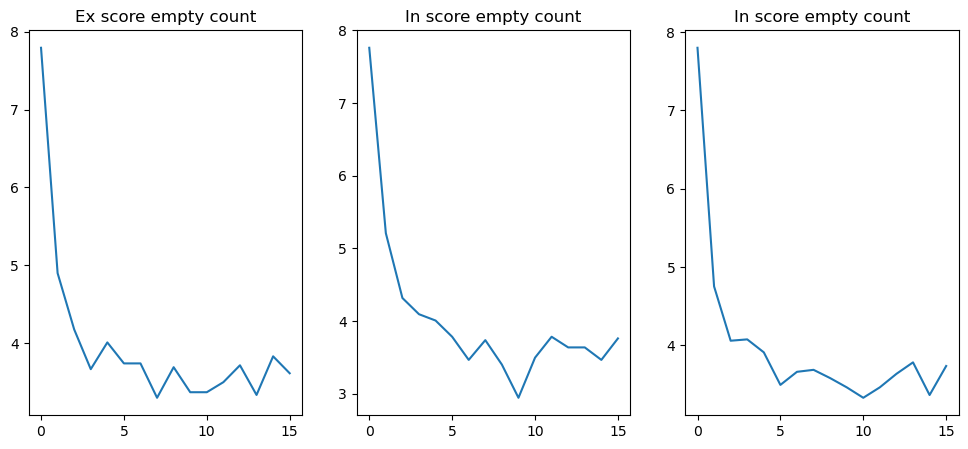

In [10]:
print("EX SCORE PARTITION SIZES")
for p in partitions_ex:
    print(len(p), end = " ")
print(f"\n{partitionsEmptyCount_ex}")
print("\nIN SCORE PARTITION SIZES")
for p in partitions_in:
    print(len(p), end = " ")
print(f"\n{partitionsEmptyCount_in}")
print("\nPROD SCORE PARTITION SIZES")
for p in partitions_prod:
    print(len(p), end = " ")
print(f"\n{partitionsEmptyCount_prod}")

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(range(16), np.log(partitionsEmptyCount_ex))
plt.title("Ex score empty count")
plt.subplot(1,3,2)
plt.plot(range(16), np.log(partitionsEmptyCount_in))
plt.title("In score empty count")
plt.subplot(1,3,3)
plt.plot(range(16), np.log(partitionsEmptyCount_prod))
plt.title("In score empty count")

In [11]:
all_partition_prod_empty = []
space_by_tens = np.linspace(0, 1, 11)

for i in space_by_tens:
    deduplicated_scores_prod = []

    for term in data:
        key = term["simplified"]
        deduplicated_scores_prod.append(i * deduplicated_dictionary_ex[key] + (1-i) * deduplicated_dictionary_in[key])

    percentiles_prod = [np.percentile(deduplicated_scores_prod, p) for p in percentiles]
    partitionsEmptyCount_prod = [0] * NUM_PARTITIONS
    for term, sentences in unifiedSentenceDB.items():
        prod_score = i * deduplicated_dictionary_ex[term] + (1-i) * deduplicated_dictionary_in[term]
        partition_idx = 0
        while partition_idx < NUM_PARTITIONS - 1 and prod_score > percentiles_prod[partition_idx + 1]:
            partition_idx += 1
        if len(sentences) == 0:
            partitionsEmptyCount_prod[partition_idx] += 1

    all_partition_prod_empty.append(np.array(partitionsEmptyCount_prod))


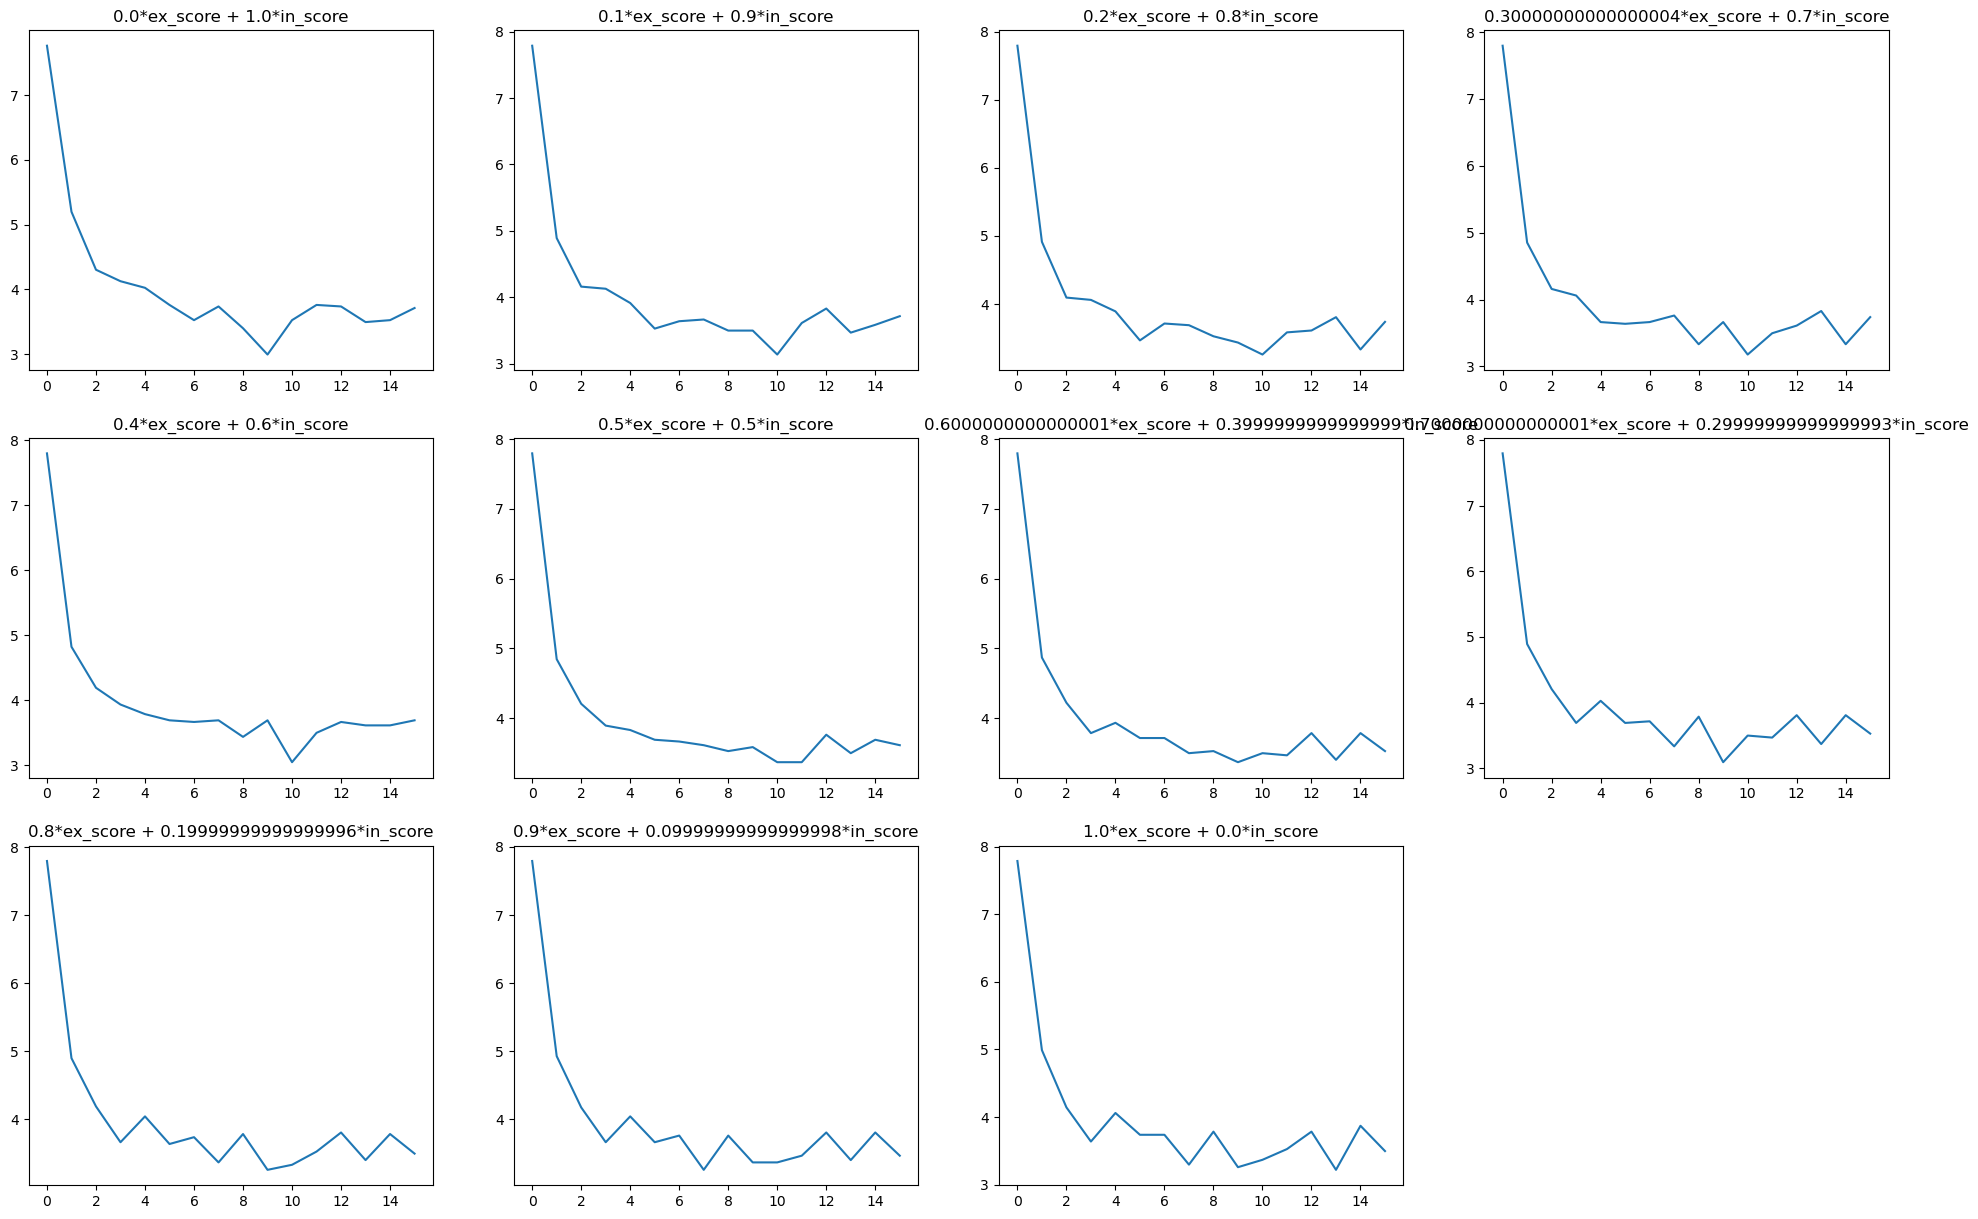

In [12]:
# print(all_partition_prod_empty)
plt.figure(figsize=(24,15))
x, y = 1, 1
for i in range(len(space_by_tens)):
    plt.subplot(3,4,int(i+1))
    plt.plot(range(NUM_PARTITIONS), np.log(all_partition_prod_empty[i]))
    plt.title(f"{space_by_tens[i]}*ex_score + {1-space_by_tens[i]}*in_score")

In [13]:
deduplicated_scores_prod = []
partitions_prod = [{} for _ in range(NUM_PARTITIONS)]
for term in data:
    key = term["simplified"]
    deduplicated_scores_prod.append(0.5 * deduplicated_dictionary_ex[key] + 0.5 * deduplicated_dictionary_in[key])

percentiles_prod = [np.percentile(deduplicated_scores_prod, p) for p in percentiles]
partitionsEmptyCount_prod = [0] * NUM_PARTITIONS
for term, sentences in unifiedSentenceDB.items():
    prod_score = 0.5 * deduplicated_dictionary_ex[term] + 0.5 * deduplicated_dictionary_in[term]
    partition_idx = 0
    while partition_idx < NUM_PARTITIONS - 1 and prod_score > percentiles_prod[partition_idx + 1]:
        partition_idx += 1
        
    partitions_prod[partition_idx][term] = sentences

print(percentiles_prod)


[0.0, 1000.0, 2460.0, 3754.0, 4935.5, 6070.0, 7210.5, 8364.28125, 9593.0, 10950.0, 12523.5, 14283.5, 16476.5, 19241.0, 23184.0625, 30196.6875, 290200.0]


In [14]:
# for idx, p in enumerate(partitions_prod):
#     with open(f'partitions/{idx}.json', 'w', encoding='utf-8') as f:
#         json.dump(p, f, ensure_ascii=False, indent=4)